# **Colab에 Mecab 설치 및 필요한 라이브러리 임포트**

In [ ]:
# install Mecab in Colab 
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 21.68 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 665 kB/s 
     |████████████████████████████████| 453 kB 61.9 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-07-21 10:07:08--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::6b17:d1f5, 2406:da00:ff00::22e9:9f55, ...
Connecting to bitbucket.org (b

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# **데이터** **로드 하기** 

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

NameError: ignored

In [ ]:
# Adding title of columns: ratings & reviews  
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])

# Print Total number of reviews
print('Total number of reviews :',len(total_data)) 

# Print Top 5 datas
total_data[:5]

# **훈련 데이터와 테스트 데이터 분리하기**

 평점이 4, 5인 리뷰에는 레이블 1을, 

 평점이 1, 2인 리뷰에는 레이블 0을 부여

 긍/부정으로 분류하기 애매한 3점에 해당하는 텍스트들은 제외

In [ ]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [ ]:
# 중복을 제외한 샘플의 수 카운트
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [ ]:
# reviews 열에서 중복인 내용이 있다면 중복 제거

# Remove duplicate content in the reviews column
total_data.drop_duplicates(subset=['reviews'], inplace=True) 
print('Total number of samples (except duplication) :',len(total_data))

Total number of samples (except duplication) : 199908


In [ ]:
print(total_data.isnull().values.any())

False


In [ ]:
# 훈련 데이터와 테스트 데이터를 3:1 비율로 분리
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('The number of training data :', len(train_data))
print('The number of test data :', len(test_data))

The number of training data : 149931
The number of test data : 49977


# **레이블의 분포 확인**

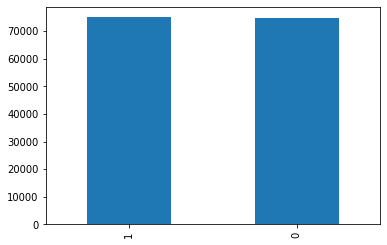

In [ ]:
# 훈련 데이터 분포 확인
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  74918
1      1  75013


 약 50:50 비율 가짐!

# **데이터 정제하기**

In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


ratings    0
reviews    0
label      0
dtype: int64


In [ ]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


# **토큰화**

In [ ]:
mecab = Mecab()
print(mecab.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이', '라고', '차라리', '내', '가', '만드', '는', '게', '나을', '뻔']


In [ ]:
#불용어를 지정, 필요없는 토큰들 제거
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [ ]:
#훈련 데이터에 대해서 위와 동일한 작업
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
#테스트 데이터에 대해서 위와 동일한 작업
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

# **단어와 길이 분포 확인하기**

긍정/ 부정 리뷰에 주로 어떤 단어가 나오는지 파악하기 위해 빈도수 계산

In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

NameError: ignored

In [ ]:
# 부정 단어
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

In [ ]:
# 긍정 단어
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5)) #그래프 그리기

#레이블 1 긍정적 리뷰
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x)) 
ax1.hist(text_len, color='red')       #빨간색
ax1.set_title('Positive Reviews')     #그래프 제목 = 개별 서브 플롯의 타이틀
ax1.set_xlabel('length of samples')   #x축 : 리뷰의 길이
ax1.set_ylabel('number of samples')   #y축 : 리뷰의 수
print('긍정 리뷰의 평균 길이 :', np.mean(text_len)) #평균 길이 출력

#레이블 0 부정적 리뷰
text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')    #파란색
ax2.set_title('Negative Reviews')   #그래프 제목 = 개별 서브 플롯의 타이틀
fig.suptitle('Words in texts')      #전체 그래프(2개)의 제목 = 공통인 메인 타이틀
ax2.set_xlabel('length of samples') #x축 : 리뷰의 길이
ax2.set_ylabel('number of samples') #y축 : 리뷰의 수
print('부정 리뷰의 평균 길이 :', np.mean(text_len)) #평균 길이 출력

#그래프 출력
plt.show()

평균적으로 부정적인 리뷰가 좀 더 길게 작성된 것을 확인할 수 있음

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

# **정수 인코딩**

훈련 데이터에 대해서 단어 집합(vocaburary) 만들기

*   **Tokenizer** :  문장으로부터 단어를 토큰화하고, 숫자에 대응시키는 딕셔너리를 사용할 수 있도록 해줌
*   **fit_on_texts()** : 문자 데이터를 입력받아서 리스트의 형태로 변환


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

등장 횟수가 1회인 단어들은 자연어 처리에서 배제하기



In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39997
등장 빈도가 1번 이하인 희귀 단어의 수: 18212
단어 집합에서 희귀 단어의 비율: 45.53341500612546
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7935259575621343


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21787


In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# 샘플 출력
print('훈련 데이터 샘플 출력',X_train[:3])
print('테스트 데이터 샘플 출력',X_test[:3])

훈련 데이터 샘플 출력 [[67, 2060, 299, 14260, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2], [46, 24, 825, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]
테스트 데이터 샘플 출력 [[14, 704, 767, 116, 186, 252, 12], [339, 3904, 62, 3816, 1651], [11, 69, 2, 49, 164, 3, 27, 15, 6, 513, 289, 17, 92, 110, 564, 59, 7, 2]]


# **패딩**

서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주기

우선 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 확인

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.307528129606286


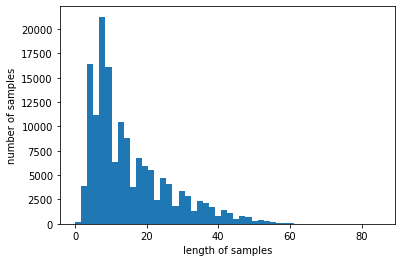

In [ ]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 전체 샘플 중 길이가 max len 이하인 샘플의 비율을 출력하는 함수
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len): #길이가 max_len 이하 이면
        count = count + 1         #count+1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

최대 길이가 85이므로 만약 80으로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있는지 확인

In [ ]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


99.99% 보존 가능. 80으로 패딩

In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# **GRU로 네이버 쇼핑 리뷰 감성 분류하기**

이진 분류 문제의 경우, 출력층에 로지스틱 회귀를 사용해야 하므로 
*   활성화 함수 : 시그모이드 함수
*   손실 함수 : 크로스 엔트로피 함수



하이퍼파라미터
*   배치 크기:  64
*   에포크 : 15



In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2733 - acc: 0.8979
Epoch 1: val_acc improved from -inf to 0.91673, saving model to best_model.h5
1875/1875 [==============================] - 317s 167ms/step - loss: 0.2733 - acc: 0.8979 - val_loss: 0.2330 - val_acc: 0.9167
Epoch 2/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2152 - acc: 0.9221
Epoch 2: val_acc improved from 0.91673 to 0.92087, saving model to best_model.h5
1875/1875 [==============================] - 327s 174ms/step - loss: 0.2152 - acc: 0.9221 - val_loss: 0.2157 - val_acc: 0.9209
Epoch 3/15
1875/1875 [==============================] - ETA: 0s - loss: 0.1983 - acc: 0.9289
Epoch 3: val_acc improved from 0.92087 to 0.92643, saving model to best_model.h5
1875/1875 [==============================] - 303s 162ms/step - loss: 0.1983 - acc: 0.9289 - val_loss: 0.2045 - val_acc: 0.9264
Epoch 4/15
1875/1875 [==============================] - ETA: 0s - loss: 0.1871 - acc: 0.9334
Epoch 4

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 34s 22ms/step - loss: 0.2081 - acc: 0.9249

 테스트 정확도: 0.9249


# **리뷰 예측해보기**

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

97.05% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

99.48% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

93.50% 확률로 부정 리뷰입니다.
